In [ ]:
!pip install rdkit-pypi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from sklearn import svm
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import Descriptors3D
from rdkit.Chem import Lipinski
from rdkit.Chem import EnumerateHeterocycles
from rdkit.Chem import Fragments
import scipy

In [ ]:
loadedModel=pickle.load(open('/content/research_rf_model_24_inputs.pkl','rb'))

In [ ]:
logP=pd.read_excel('/content/Medicamentos_más_vendidos.xlsx')
logP.head()

,Molécula,SMILES,logP,Fuente
0,ibuprofeno,CC(CC1=CC=C(C(C(O)=O)C)C=C1)C,3.75,Chemdraw
1,diclofenaco,OC(CC1=C(NC2=C(Cl)C=CC=C2Cl)C=CC=C1)=O,4.12,Chemdraw
2,resveratrol,OC1=CC(O)=CC(C=CC2=CC=C(O)C=C2)=C1,3.06,Chemdraw
3,furosemide,O=C(C1=C(NCC2=CC=CO2)C=C(Cl)C(S(=O)(N)=O)=C1)O,0.74,Chemdraw
4,fluticasona,C[C@@]12[C@@](C(SCF)=O)([C@@H](C[C@]1([C@@]3(C...,3.12,Chemdraw


In [ ]:
logP.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Molécula  20 non-null     object 
 1   SMILES    20 non-null     object 
 2   logP      21 non-null     float64
 3   Fuente    21 non-null     object 
dtypes: float64(1), object(3)
memory usage: 800.0+ bytes


In [ ]:
logP=logP.dropna()

In [ ]:
mols=[]
for i in logP['SMILES']:
  mols.append(Chem.MolFromSmiles(i))

In [ ]:
logP['mol'] = logP['SMILES'].apply(lambda x: Chem.MolFromSmiles(x)) 
logP['mol'] = logP['mol'].apply(lambda x: Chem.AddHs(x))
def number_of_atoms(atom_list, data):
    for i in atom_list:
        data['num_of_{}_atoms'.format(i)] = data['mol'].apply(lambda x: len(x.GetSubstructMatches(Chem.MolFromSmiles(i))))

number_of_atoms(['C','O', 'N', 'Cl','P','S'], logP)
from rdkit.Chem import Descriptors
logP['tpsa'] = logP['mol'].apply(lambda x: Descriptors.TPSA(x))
logP['mol_w'] = logP['mol'].apply(lambda x: Descriptors.ExactMolWt(x))
logP['MaxAbsPartialCharge'] = logP['mol'].apply(lambda x: Descriptors.MaxAbsPartialCharge(x, force=False))
logP['MaxPartialCharge'] = logP['mol'].apply(lambda x: Descriptors.MaxPartialCharge(x, force=False))
logP['MinAbsPartialCharge'] = logP['mol'].apply(lambda x: Descriptors.MinAbsPartialCharge(x, force=False))
logP['MinPartialCharge'] = logP['mol'].apply(lambda x: Descriptors.MinPartialCharge(x, force=False))
logP['num_valence_electrons'] = logP['mol'].apply(lambda x: Descriptors.NumValenceElectrons(x))
logP['num_heteroatoms'] = logP['mol'].apply(lambda x: Descriptors.NumHeteroatoms(x))
logP['Num_Rings']=logP['mol'].apply(lambda x: rdMolDescriptors.CalcNumRings(x))
logP['Num_Rotatable_Bonds']=logP['mol'].apply(lambda x: rdMolDescriptors.CalcNumRotatableBonds(x))
logP['Num_Saturated_Rings']=logP['mol'].apply(lambda x: rdMolDescriptors.CalcNumSaturatedRings(x))
logP['Num_Heterocycles']=logP['mol'].apply(lambda x: rdMolDescriptors.CalcNumHeterocycles(x))
logP['Num_Aliphatic_Carbocycles']=logP['mol'].apply(lambda x: rdMolDescriptors.CalcNumAliphaticCarbocycles(x))
logP['Num_Aliphatic_Heterocycles']=logP['mol'].apply(lambda x: rdMolDescriptors.CalcNumAliphaticHeterocycles(x))
logP['Num_Aliphatic_Rings']=logP['mol'].apply(lambda x: rdMolDescriptors.CalcNumAliphaticRings(x))
logP['Num_Amide_Bonds']=logP['mol'].apply(lambda x: rdMolDescriptors.CalcNumAmideBonds(x))
logP['Num_Aromatic_Carbocycle']=logP['mol'].apply(lambda x: rdMolDescriptors.CalcNumAromaticCarbocycles(x))
logP['Num_Aromatic_Heterocyle']=logP['mol'].apply(lambda x: rdMolDescriptors.CalcNumAromaticHeterocycles(x))
logP['Num_Aromatic_rings']=logP['mol'].apply(lambda x: rdMolDescriptors.CalcNumAromaticRings(x))
logP['Heterotatoms/C_atoms']=logP['num_heteroatoms']/logP['num_of_C_atoms']
logP['H_bonds_donors']=logP['mol'].apply(lambda x: Chem.Lipinski.NumHDonors(x))

In [ ]:
logP.columns

Index(['Molécula', 'SMILES', 'logP', 'Fuente', 'mol', 'num_of_C_atoms',
       'num_of_O_atoms', 'num_of_N_atoms', 'num_of_Cl_atoms', 'num_of_P_atoms',
       'num_of_S_atoms', 'tpsa', 'mol_w', 'MaxAbsPartialCharge',
       'MaxPartialCharge', 'MinAbsPartialCharge', 'MinPartialCharge',
       'num_valence_electrons', 'num_heteroatoms', 'Num_Rings',
       'Num_Rotatable_Bonds', 'Num_Saturated_Rings', 'Num_Heterocycles',
       'Num_Aliphatic_Carbocycles', 'Num_Aliphatic_Heterocycles',
       'Num_Aliphatic_Rings', 'Num_Amide_Bonds', 'Num_Aromatic_Carbocycle',
       'Num_Aromatic_Heterocyle', 'Num_Aromatic_rings', 'Heterotatoms/C_atoms',
       'H_bonds_donors'],
      dtype='object')

In [ ]:
X=logP.drop(columns=['Molécula','SMILES','Fuente','mol','logP'])

In [ ]:
predictions=loadedModel.predict(X)

In [ ]:
X['logP_prediction']=predictions

In [ ]:
experimental_logPs=[3.97,4.51,np.NAN,2.03,np.NAN,1.18,0.91,2.23,4.68,-2.6,2.39,np.NAN,0.07,1.34,np.NAN,0.87,1.9,1.4,3.08,2.82]

In [ ]:
X['experimental_logp']=experimental_logPs

In [ ]:
X['relative_percent_difference']=((X['experimental_logp']-X['logP_prediction'])/(abs(X['logP_prediction'])+abs(X['experimental_logp'])))*2

In [ ]:
X['|relative_percent_difference|']=abs(((X['experimental_logp']-X['logP_prediction'])/(abs(X['logP_prediction'])+abs(X['experimental_logp'])))*2)

In [ ]:
list_rpd=list(X['relative_percent_difference'])
list_prediction_class=[]
for i in range(len(list_rpd)):
  if list_rpd[i]==0:
    list_prediction_class.append(1)
  elif list_rpd[i]>= -0.3 and list_rpd[i]<= 0.3:
    list_prediction_class.append(1)
  else:
    list_prediction_class.append(0)

In [ ]:
X['prediction_class']=list_prediction_class

In [ ]:
predictions

array([ 1.418, -0.009, -1.206, -2.845, -1.171, -0.925, -0.022, -1.008,
       -0.786, -1.55 , -0.73 , -1.009, -1.539,  2.002,  0.722, -2.938,
       -2.013, -1.456,  0.496,  1.744])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Unrecognized location 'upper-left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  This is separate from the ipykernel package so we can avoid doing imports until


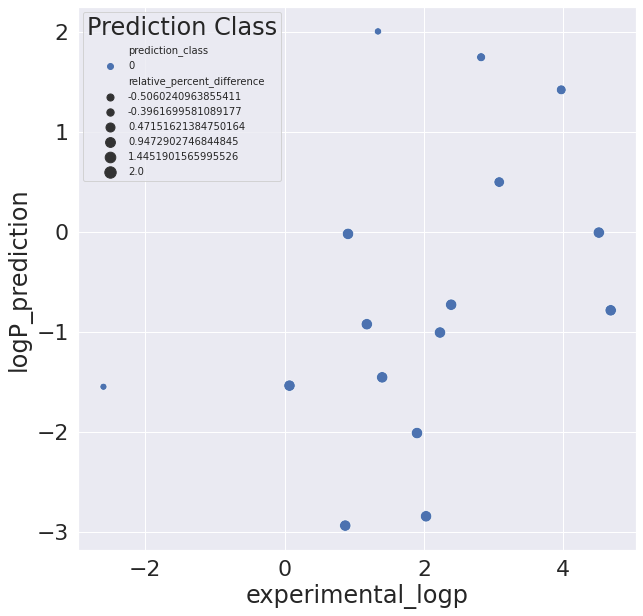

In [ ]:
plt.figure(figsize=(10,10))
sns.scatterplot(x='experimental_logp',y='logP_prediction',data= X,hue='prediction_class',size='relative_percent_difference',sizes=(50,130))
plt.legend(loc='upper-left',prop={'size':10},fancybox=True,title='Prediction Class')
sns.set(font_scale=2)
sns.set_style('darkgrid')
plt.show()

In [ ]:
predictionsDf=X[['logP_prediction','experimental_logp']]

In [ ]:
molecules_list=logP['Molécula']

In [ ]:
predictionsDf['Molecules']=molecules_list

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
predictionsDf=predictionsDf.dropna()

In [ ]:
predictionsDf.to_excel('predictionsDf.xlsx',index=False)

In [ ]:
((predictionsDf['logP_prediction'] - predictionsDf['experimental_logp'])**2).mean(axis=None)

9.751822812499995